In [9]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import scipy.io
import umap
#import cobolt
import anndata
import scanpy as sc

from sklearn.neighbors import kneighbors_graph
import sys

current_dir = os.getcwd()  # 假设当前路径是 scripts/
root_dir = os.path.abspath(os.path.join(current_dir, ".."))  # 返回项目根目录
sys.path.append(root_dir)
#import alluvial
#FIGPATH = "../Figures/mixed_source"
FIGFORMAT = "png"

In [4]:
adata = anndata.read_h5ad("../Data/cobolt_mixed.h5ad.gz")
adata

AnnData object with n_obs × n_vars = 89655 × 94507
    obs: 'barcode', 'source', 'rep', 'tech', 'celltype', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'final_ct'
    var: 'feature', 'modality', 'chr', 'start', 'end', 'n_cells'
    uns: '_scvi', 'neighbors', 'rep_colors', 'umap'
    obsm: 'X_multiVI', 'X_multiVI_nbc', 'X_umap', '_scvi_extra_categoricals'
    obsp: 'connectivities', 'distances'

In [5]:
adata.obs["final_ct"] = adata.obs.celltype.copy()
## relabel and collapse Ding annotations to existing Satpathy annotations if possible
adata.obs.final_ct = (adata.obs.final_ct
    .replace("CD14+ monocyte", "Monocyte")
    .replace("CD16+ monocyte", "Monocyte")
    .replace("Natural killer cell", "NK Cell")
    .replace("Cytotoxic T cell", "CD8+ T Cell")
    .replace("CD4+ T cell", "CD4+ T Cell")
    .replace("Plasmacytoid dendritic cell", "pDC")
    .replace("Dendritic cell", "Dendritic Cell")
    .replace("B cell", "B Cell")
)
## relabel and collapse Satpathy annotations to match existing Ding annotations if possible
adata.obs.final_ct = (adata.obs.final_ct
    .replace("Monocytes", "Monocyte")
    .replace("NK_Cells", "NK Cell")
    .replace("Naive_CD8_T_Cells", "CD8+ T Cell")
    .replace("Memory_CD8_T_Cells", "CD8+ T Cell")
    .replace("Naive_CD4_T_Cells", "CD4+ T Cell")
    .replace("Memory_CD4_T_Cells", "CD4+ T Cell")
    .replace("CD4_HelperT", "CD4+ T Cell")
    .replace("BM_pDC", "pDC")
    .replace("Dendritic_Cells", "Dendritic Cell")
    .replace("B_Cells", "B Cell")
    .replace("Regulatory_T_Cells", "TRegs")
)
adata.obs.final_ct = adata.obs.final_ct.replace("Unassigned", "Unknown")

/tmp/ipykernel_496822/3083315937.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace("CD14+ monocyte", "Monocyte")
/tmp/ipykernel_496822/3083315937.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace("CD16+ monocyte", "Monocyte")
/tmp/ipykernel_496822/3083315937.py:6: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace("Natural kill

In [4]:
adata_rna = adata[adata.obs.source == 'Ding',adata.var.modality == 'Gene Expression']
adata_atac = adata[adata.obs.source == 'Satpathy',adata.var.modality == 'Peaks']
adata_paired_rna = adata[adata.obs.source == '10x_arc',adata.var.modality == 'Gene Expression']
adata_paired_atac = adata[adata.obs.source == '10x_arc',adata.var.modality == 'Peaks']

In [6]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["OPENBLAS_NUM_THREADS"] = "32"
os.environ["MKL_NUM_THREADS"] = "32"
os.environ["NUMEXPR_NUM_THREADS"] = "32"
os.environ["OMP_NUM_THREADS"] = "32"
os.environ["VECLIB_MAXIMUM_THREADS"] = "32"
os.environ["BLIS_NUM_THREADS"] = "32"
torch.set_num_threads(32)

In [6]:
adata_rna.obs["dataset"] = adata_rna.obs["source"]
adata_atac.obs["dataset"] = adata_atac.obs["source"]
adata_paired_rna.obs["dataset"] = adata_atac.obs["source"]
adata_paired_atac.obs["dataset"] = adata_atac.obs["source"]

/tmp/ipykernel_1783604/91919790.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_rna.obs["dataset"] = adata_rna.obs["source"]
/tmp/ipykernel_1783604/91919790.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_atac.obs["dataset"] = adata_atac.obs["source"]
/tmp/ipykernel_1783604/91919790.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_paired_rna.obs["dataset"] = adata_atac.obs["source"]
/tmp/ipykernel_1783604/91919790.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_paired_atac.obs["dataset"] = adata_atac.obs["source"]


In [7]:
from cobolt.utils import MultiomicDataset,SingleData
from scipy import sparse

# Step 2: 构造 SingleData
rna_sd = SingleData(
    feature_name="RNA",
    dataset_name="Ding",
    feature=adata_rna.var_names.to_numpy(),
    count=sparse.csr_matrix(adata_rna.X),
    barcode=adata_rna.obs.barcode.to_numpy()
)

atac_sd = SingleData(
    feature_name="ATAC",
    dataset_name="Satpathy",
    feature=adata_atac.var_names.to_numpy(),
    count=sparse.csr_matrix(adata_atac.X),
    barcode=adata_atac.obs.barcode.to_numpy()
)

rna_paired = SingleData(
    feature_name="RNA",
    dataset_name="10x_arc",
    feature=adata_paired_rna.var_names.to_numpy(),
    count=sparse.csr_matrix(adata_paired_rna.X),
    barcode=adata_paired_rna.obs.barcode.to_numpy()
)

atac_paired = SingleData(
    feature_name="ATAC",
    dataset_name="10x_arc",
    feature=adata_paired_atac.var_names.to_numpy(),
    count=sparse.csr_matrix(adata_paired_atac.X),
    barcode=adata_paired_atac.obs.barcode.to_numpy()
)

# Step 3: 构造 MultiomicDataset
multi_dt = MultiomicDataset.from_singledata(rna_sd, atac_sd, rna_paired, atac_paired)
print(multi_dt)
#print(rna_paired.barcode)
#print(atac_paired.barcode)

A MultiomicDataset object with 2 omics:
- RNA: 9022 features, 42507 cells, 2 batches.
- ATAC: 85485 features, 59160 cells, 2 batches.
Joint cells:
- RNA, ATAC: 12012 cells.


In [21]:
from cobolt.model import Cobolt
model = Cobolt(dataset=multi_dt, lr=0.0005, n_latent=50)
model.train(num_epochs=300)

100%|██████████| 300/300 [1:12:06<00:00, 14.42s/it]


In [ ]:
import pandas as pd
model.calc_all_latent()
model.save_model('../model_trained/cobolt/cobolt_mix.pth')
# 取出 latent，并加上 obs index

Model saved to cobolt_model_50.pth


In [23]:
loc=np.array([x.obs.source.astype(str) + "~" + x.obs.barcode for x in adata])
#loc=loc.reshape(-1)

In [24]:
latent = model.get_all_latent()[0]
latent_df = pd.DataFrame(latent, index=multi_dt.get_barcode())
# 重排 latent，确保和你下游用的 AnnData 匹配
loc=loc.reshape(-1)
latent_df = latent_df.loc[loc]

# 安全赋值
adata.obsm["X_multiVI"] = latent_df.values
#adata.obsm["X_multiVI"] = latent
sc.pp.neighbors(adata, use_rep="X_multiVI")
sc.tl.umap(adata, min_dist=0.2)

In [13]:
latent = model.get_all_latent()[0]
adata.obsm["X_multiVI"] = latent
sc.pp.neighbors(adata, use_rep="X_multiVI")
sc.tl.umap(adata, min_dist=0.2)

In [10]:
adata_labelled = adata[adata.obs.final_ct.isin([
     'B Cell',
#      'Bone_Marrow',
     'CD4+ T Cell',
     'CD8+ T Cell',
     'Dendritic Cell',
#      'Megakaryocyte',
     'Monocyte',
     'NK Cell',
#      'PBMC',
#      'TRegs',
#      'Unknown',
     'pDC',
    ])].copy()

In [ ]:
import sklearn.cluster
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# 1. 提取 MultiVI 低维嵌入
latent = adata_labelled.obsm["X_multiVI"]
from sklearn.decomposition import PCA
latent = PCA(n_components=10).fit_transform(latent)

# 2. 设定聚类数（根据 ground truth 细胞类型数）
n_clusters = adata_labelled.obs["final_ct"].nunique()

# 3. 运行 K-means 聚类
kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
adata_labelled.obs["multiVI_clusters"] = kmeans.fit_predict(latent)

# 4. 计算 ARI 和 NMI
true_labels = adata_labelled.obs["final_ct"].values  # 真实细胞类型
pred_labels = adata_labelled.obs["multiVI_clusters"].values  # K-means 聚类标签

ari = adjusted_rand_score(true_labels, pred_labels)
nmi = normalized_mutual_info_score(true_labels, pred_labels)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

asw_cell_type=silhouette_score(latent, adata_labelled.obs.final_ct.values, metric='euclidean')
asw_cell_type


Adjusted Rand Index (ARI): 0.2857
Normalized Mutual Information (NMI): 0.3630


0.04623826

In [12]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import networkx as nx
from anndata import AnnData

def compute_graph_connectivity(adata: AnnData, embedding_key: str, label_key: str, k: int = 15) -> float:
    # Step 1: 获取嵌入和标签
    embedding = adata.obsm[embedding_key]
    labels = adata.obs[label_key]

    # Step 2: 创建邻接图（基于 kNN）
    knn = NearestNeighbors(n_neighbors=k+1).fit(embedding)
    distances, indices = knn.kneighbors(embedding)

    # 创建无向图（排除自身）
    G = nx.Graph()
    for i in range(len(embedding)):
        for j in indices[i][1:]:
            G.add_edge(i, j)

    # Step 3: 对每个细胞类型计算最大连通子图比例
    unique_labels = labels.unique()
    scores = []

    for label in unique_labels:
        idx = np.where(labels == label)[0]
        subgraph = G.subgraph(idx)
        if len(subgraph) == 0:
            scores.append(0.0)
            continue
        largest_cc = max(nx.connected_components(subgraph), key=len)
        scores.append(len(largest_cc) / len(idx))

    # Step 4: 平均所有细胞类型的连通性得分
    return np.mean(scores)

score = compute_graph_connectivity(
    adata=adata,
    embedding_key="X_multiVI",
    label_key="final_ct",  # 真实细胞类型
    k=50
)
print("Graph Connectivity Score:", round(score, 4))


Graph Connectivity Score: 0.976


In [ ]:
adata.write("../Data/cobolt_mixed_source.h5ad.gz", compression='gzip')

In [7]:
# 重新跑 neighbors
sc.pp.neighbors(adata, use_rep="X_multiVI", n_neighbors=100)

# 跑 iLISI
from scib.metrics import lisi_graph
import pandas as pd

ilisi, clisi = lisi_graph(
    adata=adata,
    batch_key="source",
    label_key="final_ct",
    use_rep = 'X_multiVI',
    type_="embed",
    k0=100,
)

print("iLISI score:", round(ilisi, 4))
print("cLISI score:", round(clisi, 4))


iLISI score: 0.0612
cLISI score: 0.9143


# cleanup annotations

In [14]:
adata = anndata.read_h5ad("../Data/cobolt_mixed.h5ad.gz")

In [16]:
# only keep shared, cell type specific labels
adata_labelled = adata[adata.obs.final_ct.isin([
     'B Cell',
#      'Bone_Marrow',
     'CD4+ T Cell',
     'CD8+ T Cell',
     'Dendritic Cell',
#      'Megakaryocyte',
     'Monocyte',
     'NK Cell',
#      'PBMC',
#      'TRegs',
#      'Unknown',
     'pDC',
    ])].copy()

In [18]:
nng = kneighbors_graph(adata_labelled.obsm["X_multiVI"], n_neighbors=100).tocoo()

In [19]:
anndf = pd.DataFrame({
    'self_label': adata_labelled.obs.final_ct[nng.row].astype(str).values,
    'neigh_label': adata_labelled.obs.final_ct[nng.col].astype(str).values,
    'self_source': adata_labelled.obs.source[nng.row].astype(str).values,
    'neigh_source': adata_labelled.obs.source[nng.col].astype(str).values,
})
anndf.head()

/tmp/ipykernel_3811969/177105745.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'self_label': adata_labelled.obs.final_ct[nng.row].astype(str).values,
/tmp/ipykernel_3811969/177105745.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'neigh_label': adata_labelled.obs.final_ct[nng.col].astype(str).values,
/tmp/ipykernel_3811969/177105745.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'self_source': adata_labelled.obs.sour

,self_label,neigh_label,self_source,neigh_source
0,CD4+ T Cell,CD4+ T Cell,Satpathy,Satpathy
1,CD4+ T Cell,CD4+ T Cell,Satpathy,Satpathy
2,CD4+ T Cell,CD4+ T Cell,Satpathy,Satpathy
3,CD4+ T Cell,CD4+ T Cell,Satpathy,Satpathy
4,CD4+ T Cell,CD8+ T Cell,Satpathy,Satpathy


In [20]:
set(anndf.self_source)

{'Ding', 'Satpathy'}

In [21]:
anndf = anndf.loc[anndf.self_source != anndf.neigh_source]

In [22]:
wmat = pd.crosstab(anndf.self_label, anndf.neigh_label)
wmat = (wmat.T / wmat.sum(axis=1)).T
# wmat = wmat / wmat.sum(axis=0)
# wmat

In [23]:
order = [
    'B Cell',
    'CD4+ T Cell',
    'CD8+ T Cell',
    'NK Cell',
    'Monocyte',
    'Dendritic Cell',
    'pDC',
]
wmat = wmat.loc[order, order]

Text(50.72222222222221, 0.5, '')

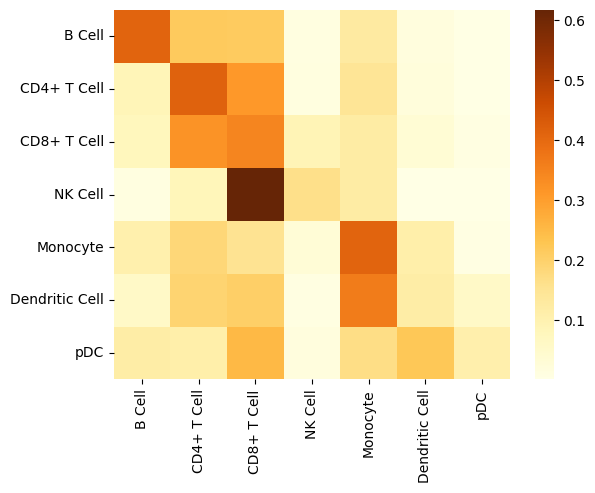

In [24]:
sns.heatmap(wmat, cmap="YlOrBr")
plt.xlabel("")
plt.ylabel("")
#plt.savefig(os.path.join(FIGPATH, "F3_annotHM.{}".format(FIGFORMAT)))

# UMAPs

In [34]:
adata.obsm["umap_wbc"] = umap.UMAP(random_state=420).fit_transform(adata.obsm["X_multiVI"])
#adata.obsm["umap_nbc"] = umap.UMAP(random_state=420).fit_transform(adata.obsm["X_multiVI_nbc"])

/home/Disk14T/xly/anaconda3/envs/cobolt/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


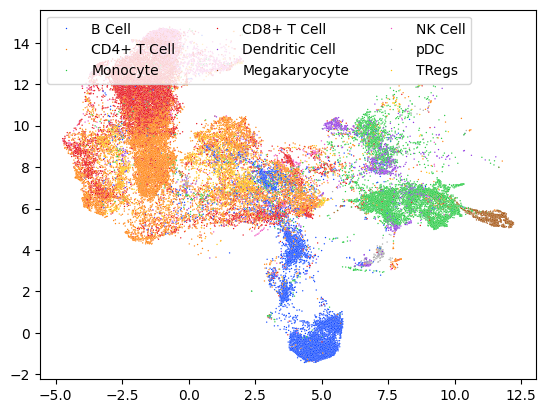

In [35]:
adata_plt = adata[np.random.choice(
        np.arange(adata.shape[0]), 
        adata.shape[0], 
        replace=False
    )].copy()
adata_plt = adata_plt[~adata_plt.obs.final_ct.isin(["Unknown", "PBMC", "Bone_Marrow"])].copy()
sns.scatterplot(
    x=adata_plt.obsm["umap_wbc"][:,0],
    y=adata_plt.obsm["umap_wbc"][:,1],
    hue=adata_plt.obs.final_ct,
    s=1,
    palette='bright',
)
plt.legend(
#     loc='lower left', 
    loc='upper left',
    ncol=3,
#     bbox_to_anchor=(1, 0.5)
)
#plt.savefig(os.path.join(FIGPATH, "F3_mixumap_ct.{}".format(FIGFORMAT)), bbox_inches='tight')

/tmp/ipykernel_3811969/3397652646.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace('Satpathy', 'scATAC (Satpathy)')
/tmp/ipykernel_3811969/3397652646.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace('Ding', 'scRNA (Ding)')
/tmp/ipykernel_3811969/3397652646.py:10: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace('10x_arc', '

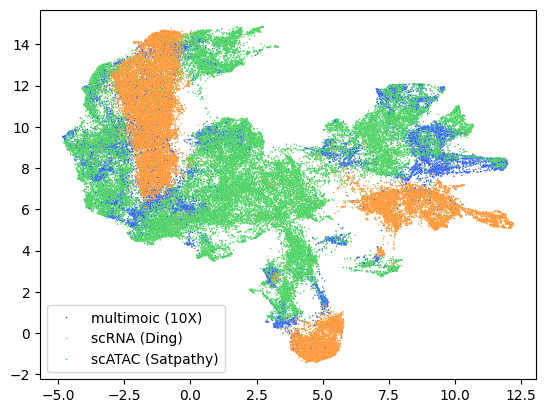

In [36]:
adata_plt = adata[np.random.choice(
        np.arange(adata.shape[0]), 
        adata.shape[0], 
        replace=False
    )].copy()
adata_plt.obs.source = (
    adata_plt.obs.source
    .replace('Satpathy', 'scATAC (Satpathy)')
    .replace('Ding', 'scRNA (Ding)')
    .replace('10x_arc', 'multimoic (10X)')
)
sns.scatterplot(
    x=adata_plt.obsm["umap_wbc"][:,0],
    y=adata_plt.obsm["umap_wbc"][:,1],
    hue=adata_plt.obs.source,
    s=1,
    palette='bright',
)
plt.legend(title='', loc='lower left')#, bbox_to_anchor=(1, 0.5))
#plt.savefig(os.path.join(FIGPATH, "F3_mixumap_source.{}".format(FIGFORMAT)), bbox_inches='tight')

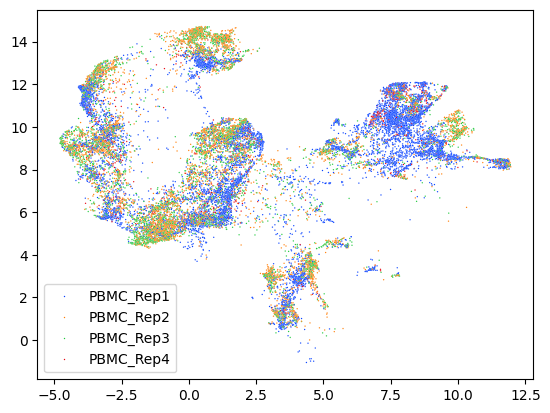

In [37]:
# plt.figure(figsize=(5,5))
adata_plt = adata[np.random.choice(
        np.arange(adata.shape[0]), 
        adata.shape[0], 
        replace=False
    )].copy()
adata_plt = adata_plt[adata_plt.obs.final_ct == "PBMC"]
sns.scatterplot(
    x=adata_plt.obsm["umap_wbc"][:,0],
    y=adata_plt.obsm["umap_wbc"][:,1],
    hue=adata_plt.obs.rep,
    s=1,
    palette='bright',
)
plt.legend(title=None)#, loc='center left') #, bbox_to_anchor=(1, 0.5),)
#plt.savefig(os.path.join(FIGPATH, "F3_mixumap_rep.{}".format(FIGFORMAT)), bbox_inches='tight')

/tmp/ipykernel_3811969/407978484.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace('10x Chromium (v2) A', '10x Chromium (v2)')
/tmp/ipykernel_3811969/407978484.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace('10x Chromium (v2) B', '10x Chromium (v2)')


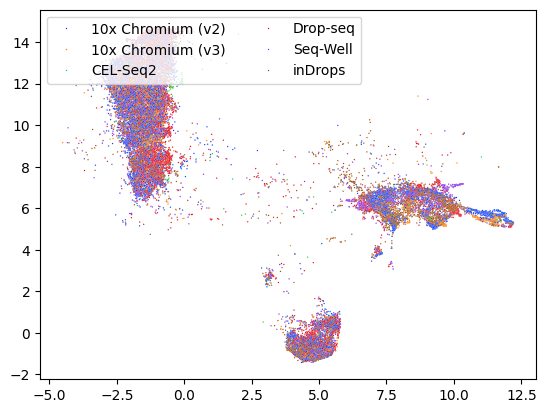

In [38]:
adata_plt = adata[np.random.choice(
        np.arange(adata.shape[0]), 
        adata.shape[0], 
        replace=False
    )].copy()
adata_plt = adata_plt[adata_plt.obs.source == "Ding"].copy()
adata_plt.obs.tech = (adata_plt.obs.tech
                      .replace('10x Chromium (v2) A', '10x Chromium (v2)')
                      .replace('10x Chromium (v2) B', '10x Chromium (v2)')
                     )
sns.scatterplot(
    x=adata_plt.obsm["umap_wbc"][:,0],
    y=adata_plt.obsm["umap_wbc"][:,1],
    hue=adata_plt.obs.tech,
    s=1,
    palette='bright',
)
plt.legend(
    loc='upper left', 
#     bbox_to_anchor=(1, 0.5), 
    ncol=2,
)
#plt.savefig(os.path.join(FIGPATH, "F3_mixumap_tech.{}".format(FIGFORMAT)), bbox_inches='tight')

In [39]:
def compute_batch_mixing(latent, batch_id, k):
    nng = kneighbors_graph(latent, n_neighbors=k).tocoo()
    batch_id = pd.Categorical(batch_id).codes
    self_id = batch_id[nng.row]
    ne_id = batch_id[nng.col]
    
    _, c = np.unique(batch_id, return_counts=True)
    theoretic_score = ((c / c.sum()) ** 2).sum()
    return (self_id == ne_id).mean() / theoretic_score

In [ ]:
latent = adata.obsm['X_multiVI']
enrichment_rep=compute_batch_mixing(latent, adata.obs.rep, 100)
asw_rep=silhouette_score(latent, adata.obs.rep, metric='euclidean')
print(enrichment_rep)
print(asw_rep)

4.054752261979088
-0.11243914


In [ ]:
enrichment_tech=compute_batch_mixing(latent, adata.obs.tech, 100)
asw_tech=silhouette_score(latent, adata.obs.tech, metric='euclidean')
print(enrichment_tech)
print(asw_tech)

1.9803038849106966
-0.056595992
